In [197]:
import re
import pickle
import numpy as np
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

In [198]:
text2chatgpt_output = pickle.load(open('text2chatgpt_output_sample_011023_temp0.p', 'rb'))

In [199]:
sample = pickle.load(open('data/db_texts.p', 'rb'))

In [200]:
augmented_records = []
for r in sample:
    if r['tg_preview_text'] in text2chatgpt_output:
        r_ = r.copy()
        r_['chatgpt_output'] = text2chatgpt_output[r['tg_preview_text']]
        augmented_records.append(r_)

In [201]:
len(augmented_records)

594

In [202]:
Counter([r['channel'] for r in augmented_records]).most_common()

[('rian_ru', 334),
 ('svtvnews', 58),
 ('tass_agency', 51),
 ('izvestia', 51),
 ('interfaxonline', 50),
 ('nexta_live', 50)]

In [203]:
augmented_records_ = []
for source in set([s['channel'] for s in augmented_records]):
    augmented_records_.extend([r for r in augmented_records if r['channel'] == source][:50])
Counter([r['channel'] for r in augmented_records_]).most_common()

[('rian_ru', 50),
 ('tass_agency', 50),
 ('izvestia', 50),
 ('interfaxonline', 50),
 ('nexta_live', 50),
 ('svtvnews', 50)]

In [204]:
augmented_records = augmented_records_

In [211]:
def parse_chatgpt_field(process_result, field):
    parsed_manipulation_methods = []
    if field not in process_result:
        return []
    lines = process_result[field].split('\n')
    for line in lines:
        method = re.findall(r'(\d+\.(.*?)[:])', line)
        if method:
            method_name = method[0][1].strip()
            if '(' in method_name:
                method_example = re.findall(r'(\((.*?)\))', method_name)[0][0]
                method_name = re.sub(r'\s+', ' ', method_name.replace(method_example, '')).strip()
            else:
                method_example = ''
            method_explanation = (method_example.strip() + " " + line.replace(method[0][0], '').strip()).strip()
            parsed_manipulation_methods.append((method_name, method_explanation))
    return parsed_manipulation_methods

In [214]:
# todo: automatise with semantic embedding similarity | make stricter prompts
method2group = {'Авторитетный источник': 'group_authority_source',
 'Влияние на патриотические и националистические чувства': 'group_patriotism',
 'Влияние на патриотические чувства': 'group_patriotism',
 'Влияние на эмоции и ценности': 'group_emotions',
 'Внимание к деталям': 'group_selection',
 'Воздействие на патриотические и националистические чувства': 'group_emotions',
 'Воздействие на эмоции и ценности': 'group_emotions',
 'Использование авторитета лидера': 'group_authority_person',
 'Использование авторитетного источника': 'group_authority_source',
 'Использование выборочной информации': 'group_selection',
 'Использование единственного источника информации': 'group_selection',
 'Использование негативной коннотации': 'group_negative_connotation',
 'Использование эмоционально окрашенной лексики': 'group_emotions',
 'Манипуляция через акцентирование внимания на последствиях': 'group_consequences',
 'Манипуляция через акцентирование внимания на последствиях для личности/группы': 'group_consequences',
 'Отсутствие контекста': 'group_lack_context',
 'Отсутствие контекста и отсутствие противоположной точки зрения': 'group_lack_context',
 'Отсутствие пространства для противодействия': 'group_lack_alternative',
 'Отсутствие противоположной точки зрения': 'group_lack_alternative',
 'Подмена понятий': 'group_euphemism',
 'Подмена понятий и некорректное обобщение': 'group_euphemism',
 'Создание страха': 'group_fearmongering',
 'Создание чувства неопределенности': 'group_uncertainty',
 'Употребление патриотических тематик': 'group_patriotism',
 'Употребление патриотической тематики': 'group_patriotism',
 'Чёрно-белое мышление': 'group_radicalism',
 'Эмоциональная манипуляция': 'group_emotions',
'Некорректное обобщение': 'group_generalisation',
 'Использование патриотической тематики': 'group_patriotism',
 'Эмоциональная манипуляция через акцентирование внимания на последствиях для личности/группы': 'group_consequences',
 'Использование патриотических тематик': 'group_patriotism',
 'Отсутствие объяснения вывода': 'group_lack_justification',
 'Черно-белое мышление': 'group_radicalism',
 'Возможность использования авторитетного источника': 'group_authority_source',
 'Вывод без объяснения': 'group_lack_justification',
 'Значение акцентирования внимания на последствиях для личности/группы': 'group_consequences',
 'Создание чувства неопределённости': 'group_uncertainty',
 'Отсутствие пронумерованного списка + инфографика': 'group_lack_context',
 'Отсутствие объяснения': 'group_lack_justification',
 'Использование эмоциональной манипуляции': 'group_emotions',
 'Использование негативной коннотации и эмоционально окрашенной лексики': 'group_negative_connotation',
 'Отсутствие контекста и противоположной точки зрения': 'group_lack_context',
 'Употребление негативной коннотации': 'group_negative_connotation',
 'Манипуляция через акцентирование внимания на последствиях для личности': 'group_consequences',
 'Создание эмоциональной манипуляции': 'group_emotions',
 'Воздействие на патриотические чувства': 'group_patriotism',
 'Внимание к последствиям для личности/группы': 'group_consequences',
 'Употребление эмоционально окрашенной лексики': 'group_emotions',
 'Возможный прием': 'group_uncategorised',
 'Влияние на патриотические и националистические чувства - упор на национальность космонавтов': 'group_patriotism',
 'Манипуляция через акцентирование внимания на последствиях для группы': 'group_consequences',
 'Манипуляция через эмоционально окрашенную лексику': 'group_emotions',
 'Использование выборочной информации и отсутствие противоположной точки зрения': 'group_selection',
 'Использование негативной коннотации и эмоциональной манипуляции': 'group_negative_connotation',
 'Отсутствие контекста и подмена понятий': 'group_euphemism',
 'Возможность манипуляции через акцентирование внимания на последствиях для личности/группы': 'group_consequences',
 'Употребление деталей': 'group_selection',
 'Создание чувства страха': 'group_fearmongering',
 'Употребление патриотической лексики': 'group_patriotism',
 'Использование некорректного обобщения': 'group_generalisation',
 'Возможно использование выборочной информации': 'group_selection',
 'Использование патриотических тематик - автор текста упоминает категории проектов, которые были поданы на финансирование': 'group_patriotism',
 'Использование эмоционально окрашенной лексики - автор в тексте использует выражения, которые вызывают эмоциональный отклик у читателя': 'group_emotions',
 'Подмена понятий - текст содержит фразы, которые имеют неопределенное значение или широкий интерпретации': 'group_euphemism',
 'Возможное использование негативной коннотации': 'group_negative_connotation',
 'Единственный источник информации': 'group_selection',
 'Создание неопределенности': 'group_uncertainty',
 'Использование эмоционально окрашенной лексики и эмоциональная манипуляция': 'group_emotions',
 'Подчеркивание последствий для личности/группы': 'group_consequences',
 'Выборочное использование информации': 'group_selection',
 'Влияние на националистические чувства': 'group_patriotism',
 'Воздействие на националистические чувства': 'group_patriotism',
 'Воздействие на эмоции': 'group_emotions'}

In [215]:
group2label = {'group_authority_person': 'Использование авторитета лидера',
               'group_authority_source': 'Использование авторитета источника',
               'group_patriotism': 'Влияние на патриотические и националистические чувства',
               'group_emotions': 'Эмоциональная манипуляция',
               'group_selection': 'Выборочная информация',
               'group_fearmongering': 'Создание страха',
               'group_lack_context': 'Отсутствие контекста',
               'group_lack_alternative': 'Отсутствие противоположной точки зрения',
               'group_euphemism': 'Подмена понятий',
               'group_uncertainty': 'Создание чувства неопределенности',
               'group_radicalism': 'Чёрно-белое мышление',
               'group_negative_connotation': 'Использование негативных коннотаций',
               'group_consequences': 'Акцентирования внимания на последствиях для личности/группы',
               'group_generalisation': 'Некорректное обобщение',
               'group_lack_justification': 'Отсутствие объяснения вывода',
               'group_uncategorised': '(неопределенный)'
              }

In [217]:
all_manipulation_methods = [parse_chatgpt_field(r['chatgpt_output'], 'manipulation_methods') for r in augmented_records]
source2manipulation_methods = {}
for i, r in enumerate(augmented_records):
    current_manipulation_methods = all_manipulation_methods[i]
    current_manipulation_methods = [group2label[method2group[y[0]]] for y in current_manipulation_methods]
    source2manipulation_methods[r['channel']] = source2manipulation_methods.get(r['channel'], []) + current_manipulation_methods
# {y[0]: '' for x in all_manipulation_methods for y in x if y[0] not in method2group}

In [218]:
source2manipulation_methods_cntr = {k: Counter(v).most_common() for k, v in source2manipulation_methods.items()}

In [219]:
manipulation_method2source_cntr = {}
for source, manipulation_methods_cntr in source2manipulation_methods_cntr.items():
    for manip_method, val in manipulation_methods_cntr:
        if manip_method in manipulation_method2source_cntr:
            if source in manipulation_method2source_cntr[manip_method]:
                manipulation_method2source_cntr[manip_method][source] = manipulation_method2source_cntr[manip_method][source] + val
            else:
                manipulation_method2source_cntr[manip_method][source] = val
        else:
            manipulation_method2source_cntr[manip_method] = {source: val}

In [220]:
source2num_texts = dict(Counter([x['channel'] for x in sample]))

In [221]:
def plot_method_info(manip_method):
    data = manipulation_method2source_cntr[manip_method]
    labels = list(data.keys())
    values = list(data.values())
    # percentage of the channel's publications
#     values = [np.round(x/source2num_texts[labels[i]], 2) for i, x in enumerate(values)]
    # percentage of all publications with such manipulation method
    values = [np.round(x/sum(values), 2) for i, x in enumerate(values)]

    # Plotting
    plt.figure(figsize=(5, 3))
    bars = plt.barh(labels, values, color='skyblue')

    # Adding labels to the bars
    for bar in bars:
        plt.text(bar.get_width() + 0.04, bar.get_y() + bar.get_height()/2,
                 f'{bar.get_width()}',
                 ha='center', va='center', color='black', fontsize=10)

    # Adding title and labels
    plt.title(f'Приём: {manip_method}')
    plt.xlabel('Частота')
    ax = plt.gca()
    ax.set_xlim([0, 1])

    # Display the plot
    plt.tight_layout()
    plt.show()

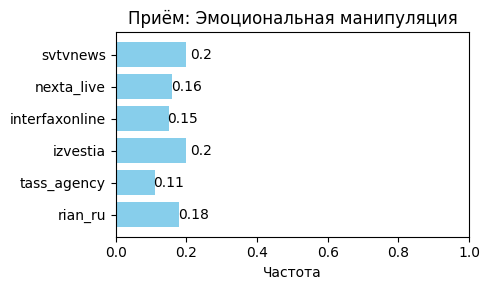

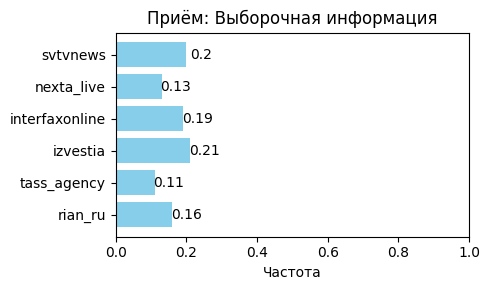

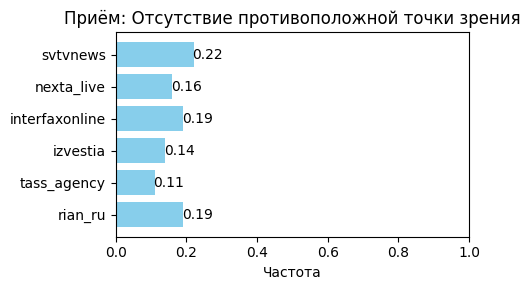

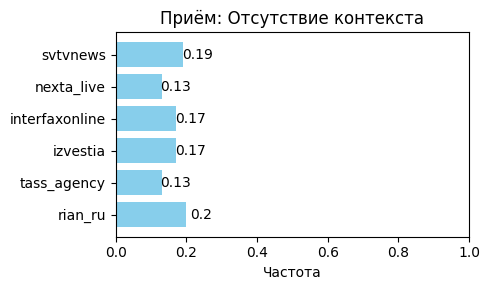

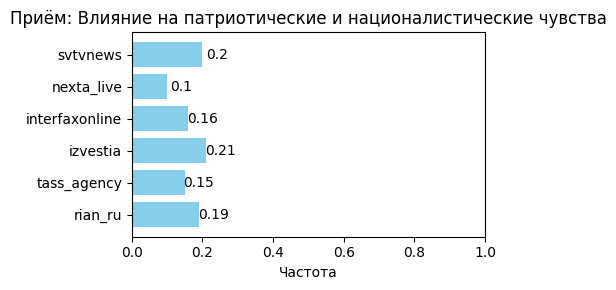

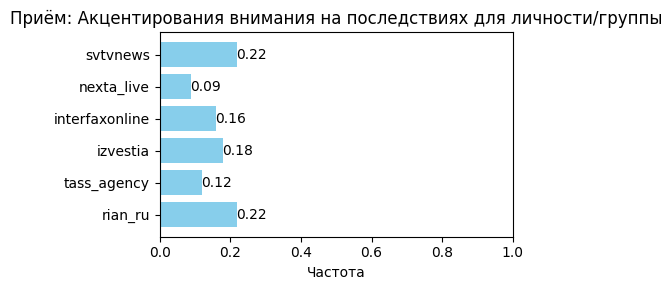

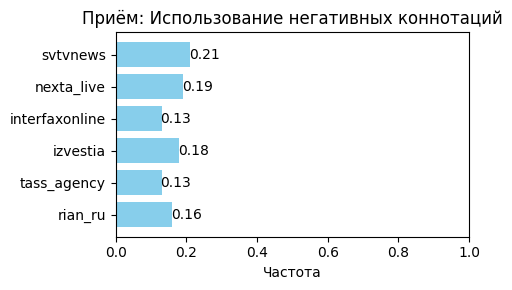

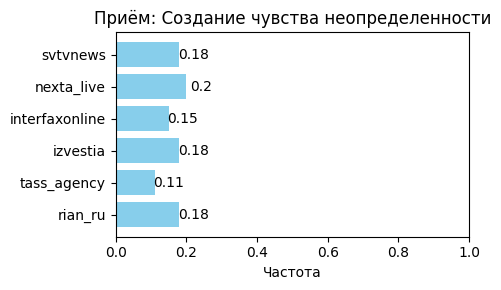

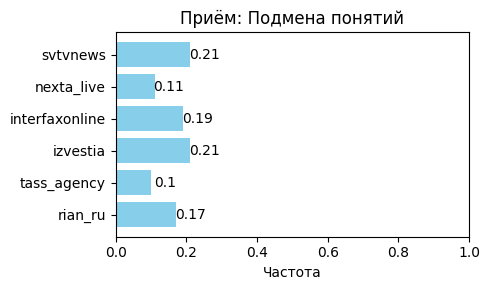

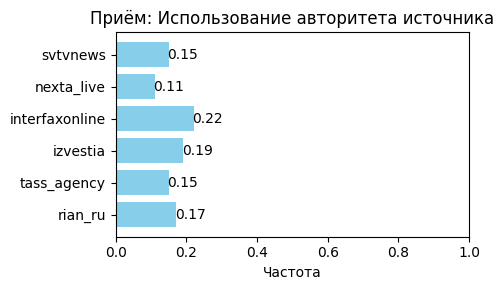

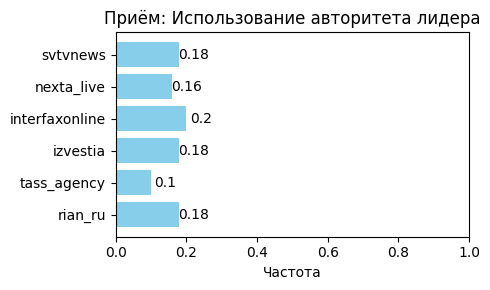

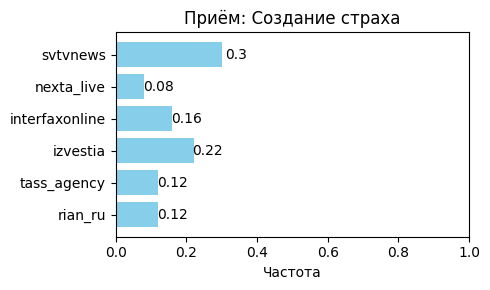

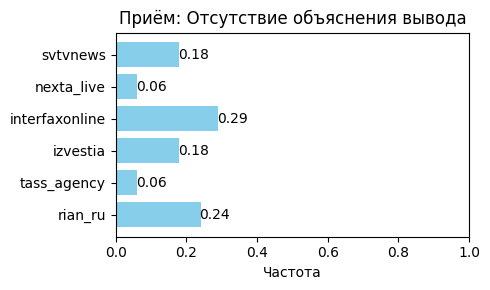

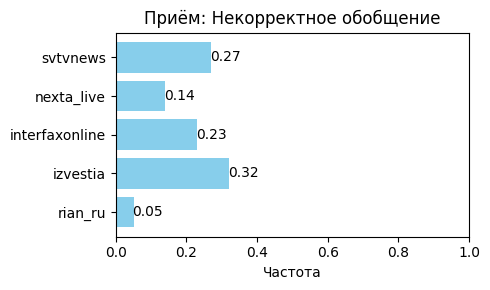

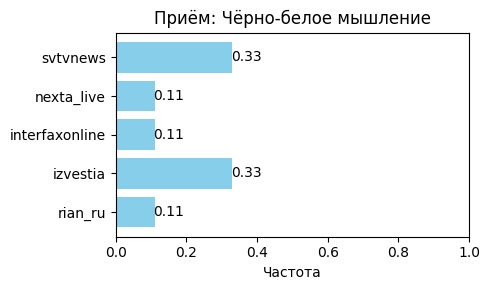

In [222]:
for manip_method in manipulation_method2source_cntr.keys():
    plot_method_info(manip_method)

In [223]:
def plot_source_info(relabeled_methods, augmented_records, source = 'rian_ru'):
    augmented_records = [r for r in augmented_records if r['channel'] == source]
    manipulation_methods = [parse_chatgpt_field(r['chatgpt_output'], 'manipulation_methods') for r in augmented_records]
    relabeled_methods = [set([group2label[method2group[y[0]]] for y in x]) for x in manipulation_methods]
    flat_relabeled_methods = [x for y in relabeled_methods for x in y]
    data = Counter(flat_relabeled_methods).most_common()
    # Sorting data by values in descending order
    data.sort(key=lambda x: x[1])

    # Extracting labels and values
    labels, values = zip(*data)
    values = [np.round(x/len(augmented_records), 2) for x in values]

    # Plotting
    plt.figure(figsize=(10, 6))
    bars = plt.barh(labels, values, color='skyblue')

    # Adding labels to the bars
    for bar in bars:
        plt.text(bar.get_width() + 0.04, bar.get_y() + bar.get_height()/2,
                 f'{bar.get_width()}',
                 ha='center', va='center', color='black', fontsize=10)

    # Adding title and labels
    plt.title(f'Приёмы манипуляции (Источник: @{source}; # текстов: {len(augmented_records)})')
    plt.xlabel('Частота')
    ax = plt.gca()
    ax.set_xlim([0, 1])

    # Display the plot
    plt.tight_layout()
    plt.show()
    return labels, values

In [225]:
def pretty_plot_source_info(labels, values, augmented_records, source):
    augmented_records = [r for r in augmented_records if r['channel'] == source]
    manip_by_freq = {}
    for l, v in zip(labels, values):
        manip_by_freq[len(manip_by_freq)] = {'manip': l, 'freq': v}
    manip_by_freq = pd.DataFrame.from_dict(manip_by_freq, orient = 'index')

    # Create the figure and axes objects, specify the size and the dots per inches 
    fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)

    # Plot bars
    bar1 = ax.barh(manip_by_freq['manip'], manip_by_freq['freq'], height=0.6)
    # Create the grid 
    ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)
    ax.set_xlim([0, 1])
    # Reformat x-axis label and tick labels
    ax.set_xlabel('', fontsize=12, labelpad=10) # No need for an axis label
    ax.yaxis.set_label_position("left")
    ax.yaxis.set_major_formatter(lambda s, i : f'{s:,.0f}')
    # ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=0)
    ax.set_yticks(manip_by_freq['manip'], labels) # Map integers numbers from the series to labels list
    # Reformat y-axis
    ax.set_xlabel('Частота', fontsize=12, labelpad=10)
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.set_major_formatter(lambda s, i : f'{s:,.1f}')
    # ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12)

    # Add label on top of each bar
    ax.bar_label(bar1, labels=[f'{e:,.2f}' for e in manip_by_freq['freq']], padding=3, color='black', fontsize=8) 
    # Remove the spines
    ax.spines[['top','left','bottom']].set_visible(False)

    # Make the left spine thicker
    ax.spines['right'].set_linewidth(1.1)

    # Add in red line and rectangle on top
    ax.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#E3120B', linewidth=.6)
    ax.add_patch(plt.Rectangle((0.12,.98), 0.04, -0.02, facecolor='#E3120B', transform=fig.transFigure, clip_on=False, linewidth = 0))

    # Add in title and subtitle
    ax.text(x=0.12, y=.93, s="Приёмы манипуляции", transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
    ax.text(x=0.12, y=.90, s=f"Источник: {source} | # текстов: {len(augmented_records)}", transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)

    # Set source text
    ax.text(x=0.1, y=0.12, s="", transform=fig.transFigure, ha='left', fontsize=10, alpha=.7)

    # Adjust the margins around the plot area
    plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

    # Set a white background
    fig.patch.set_facecolor('white')
    # Add legend
    ax.legend(loc="best", ncol=2, bbox_to_anchor=[1, 1.07], borderaxespad=0, frameon=False, fontsize=8)
    plt.show()

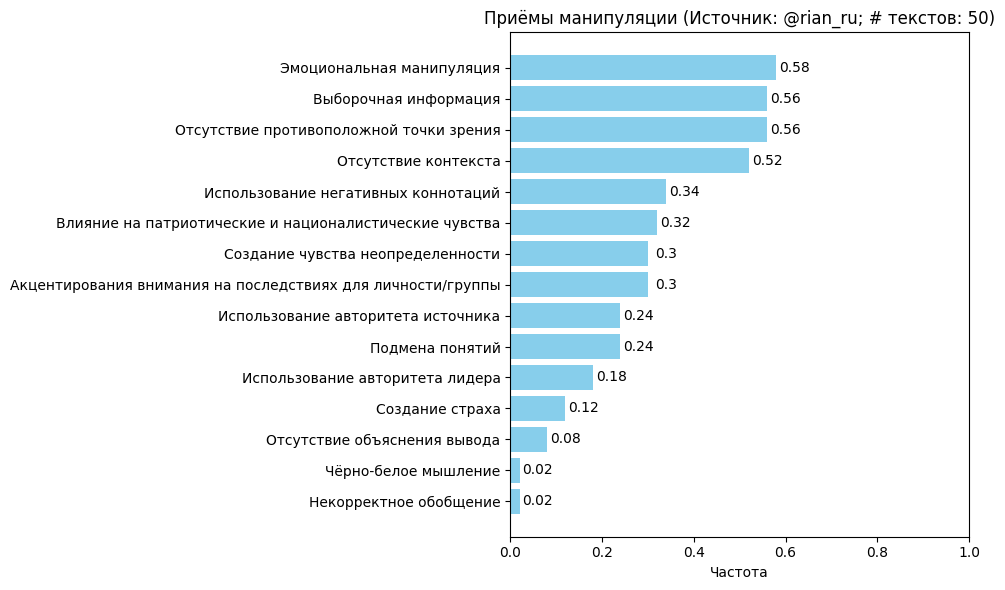

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


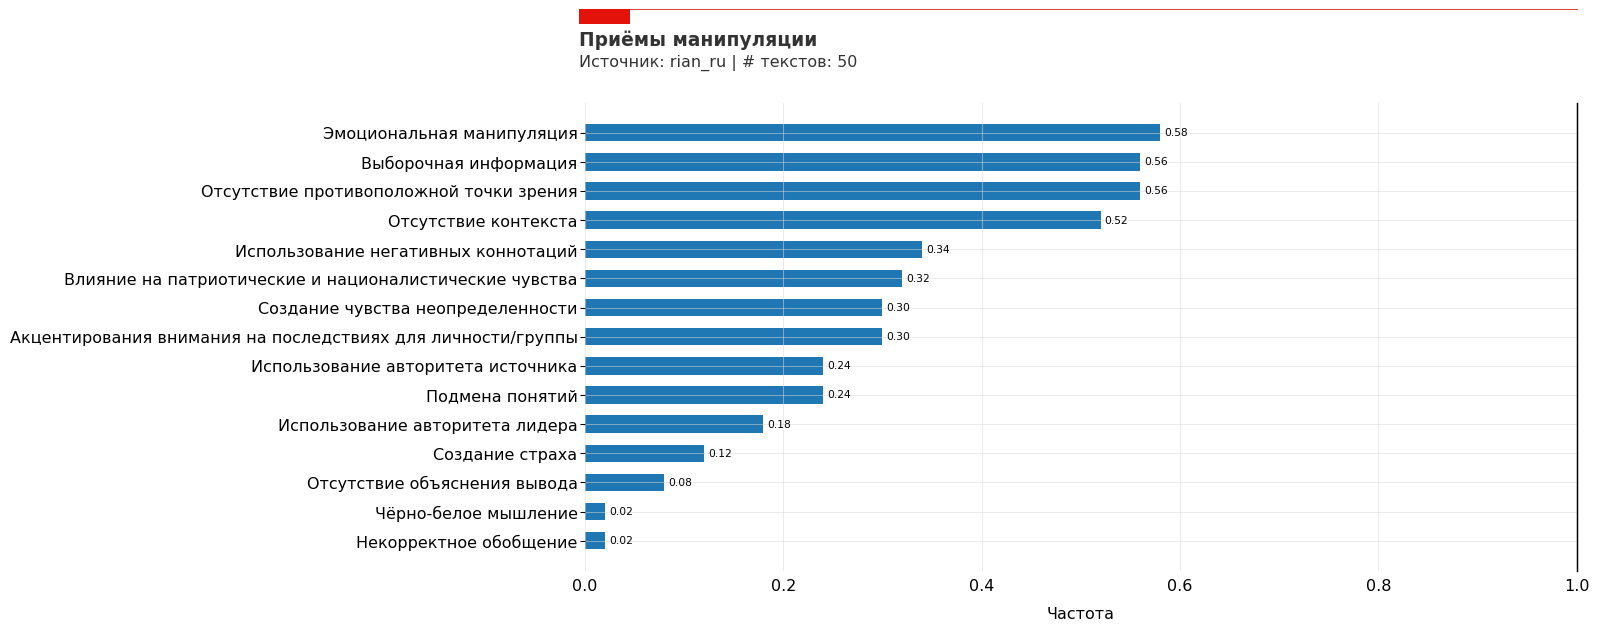

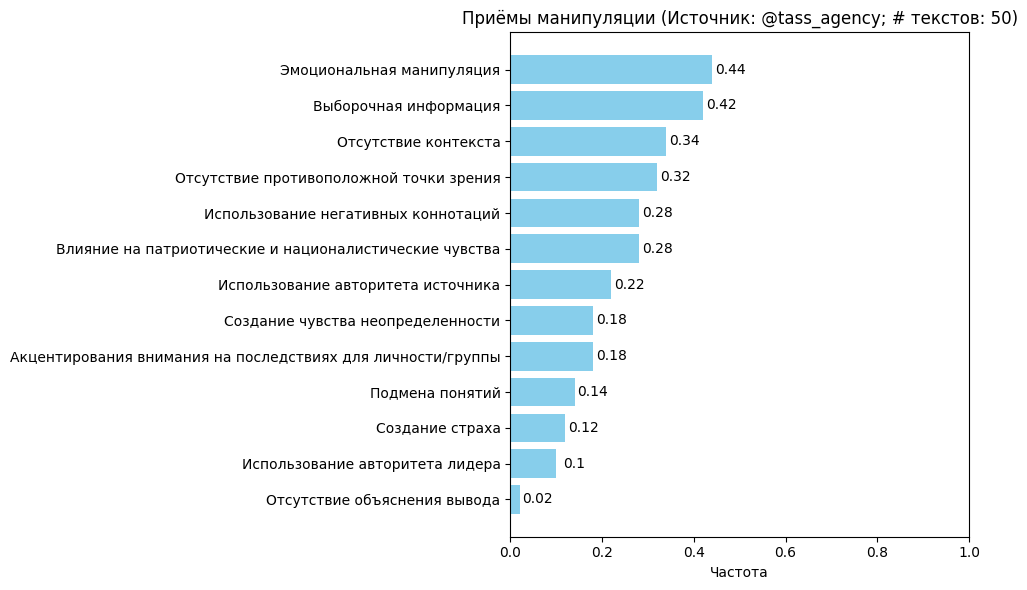

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


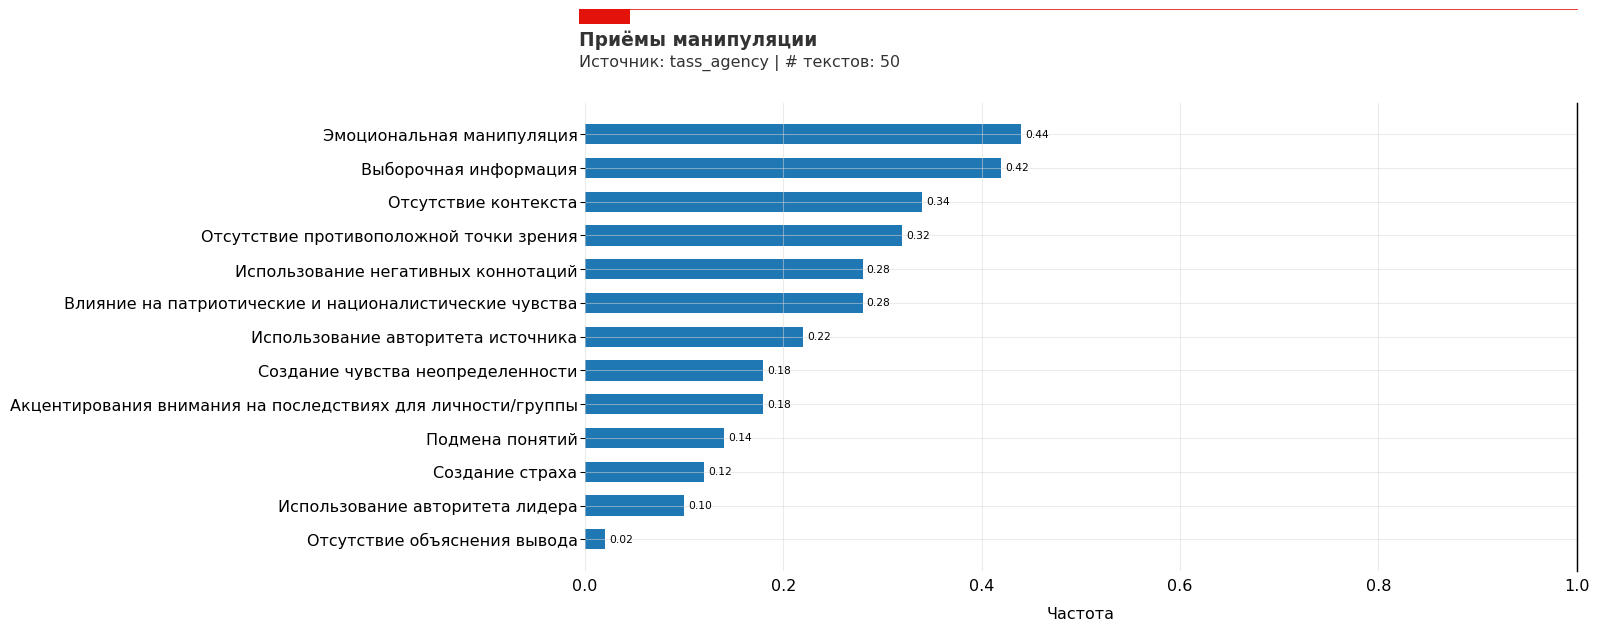

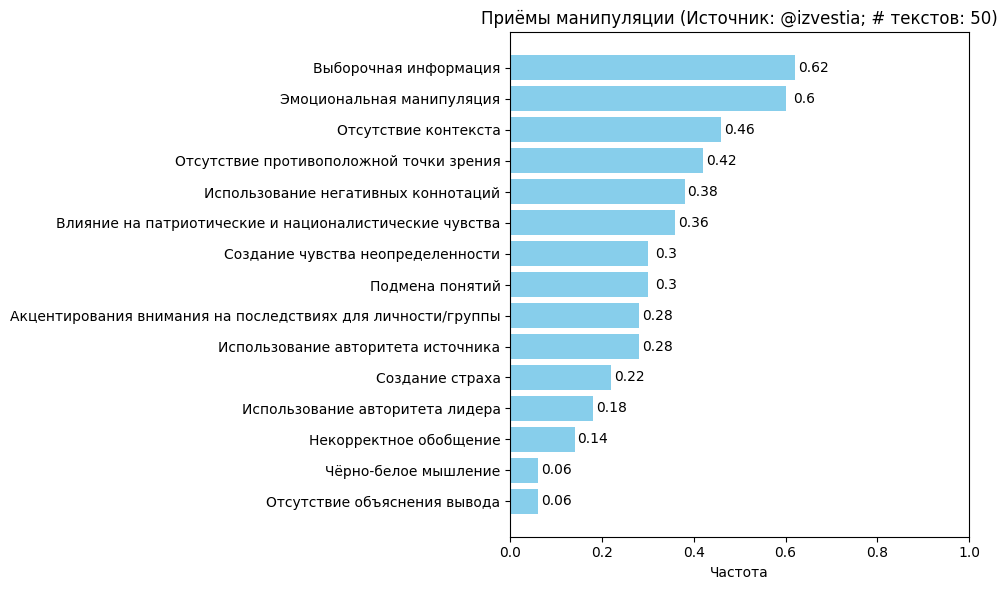

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


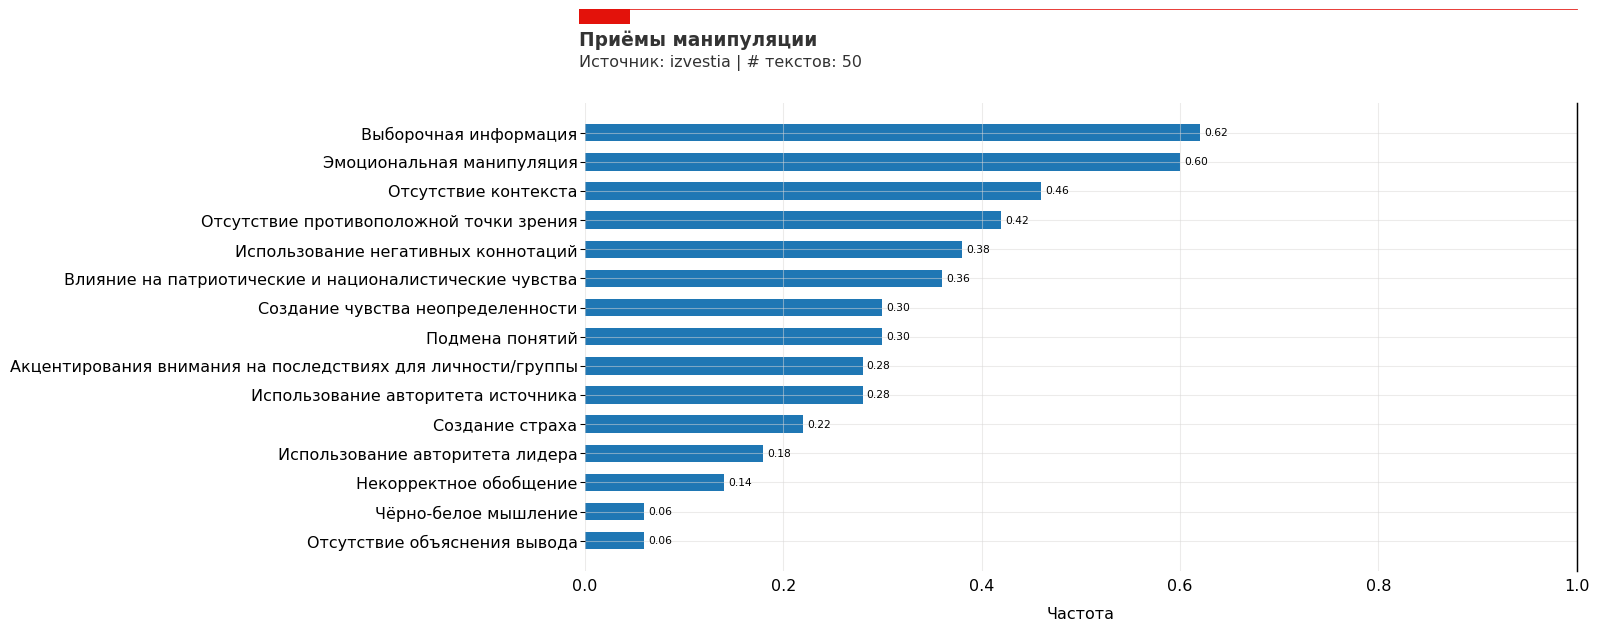

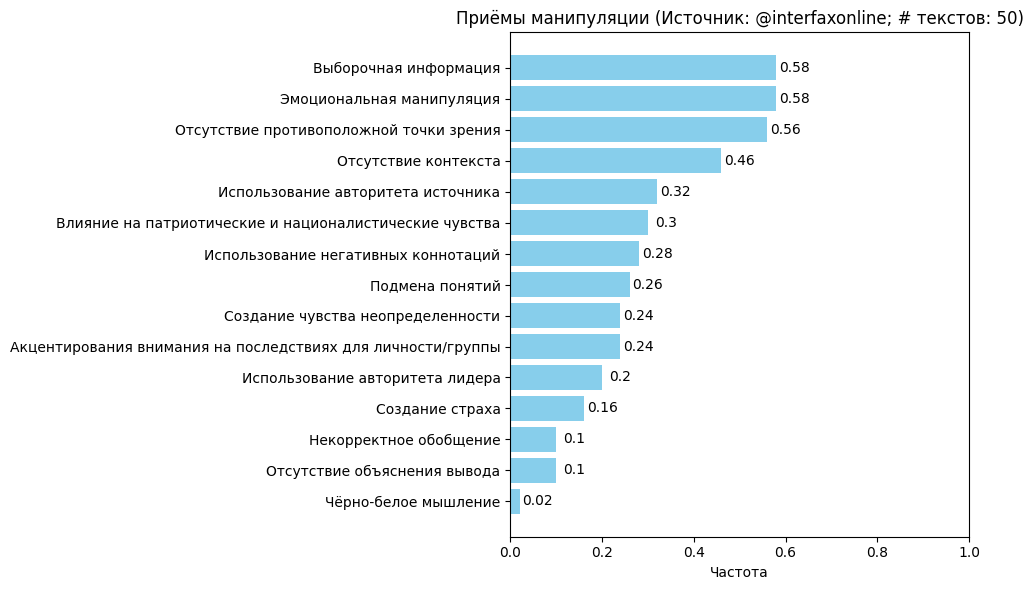

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


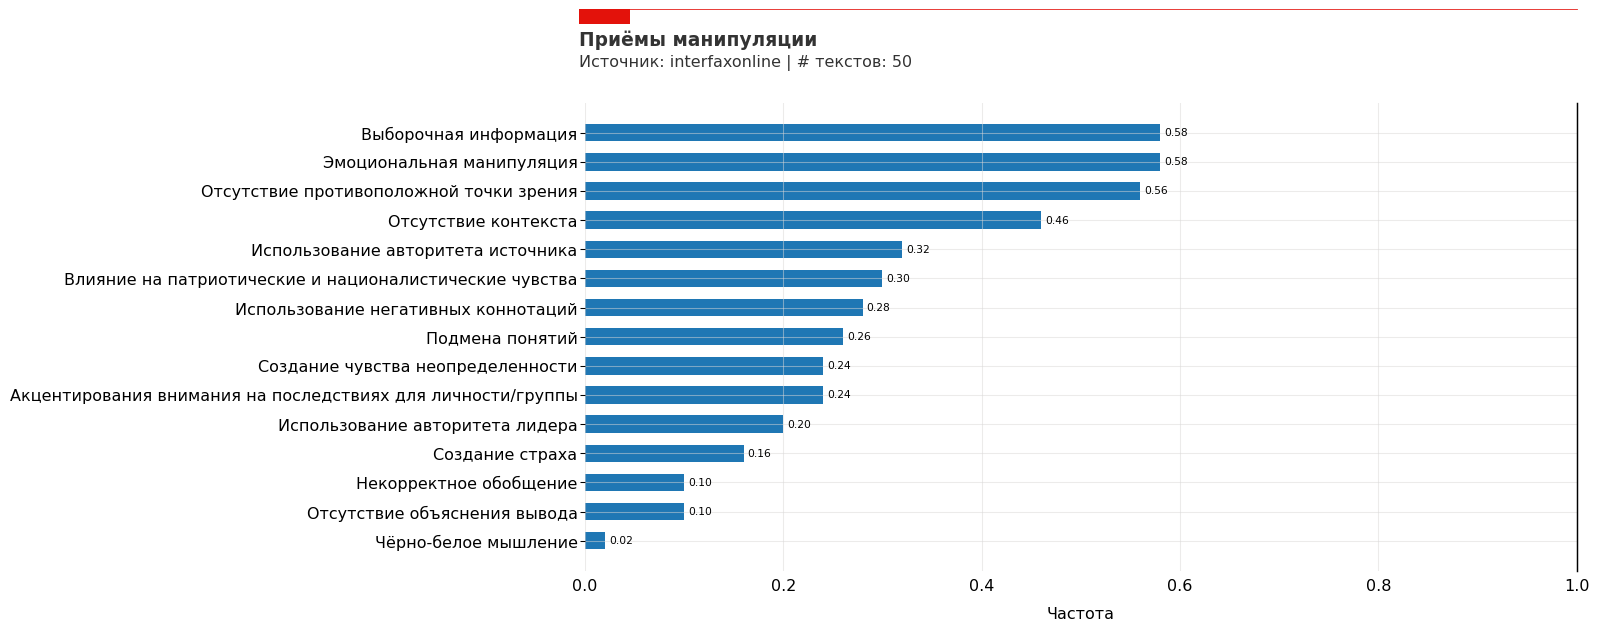

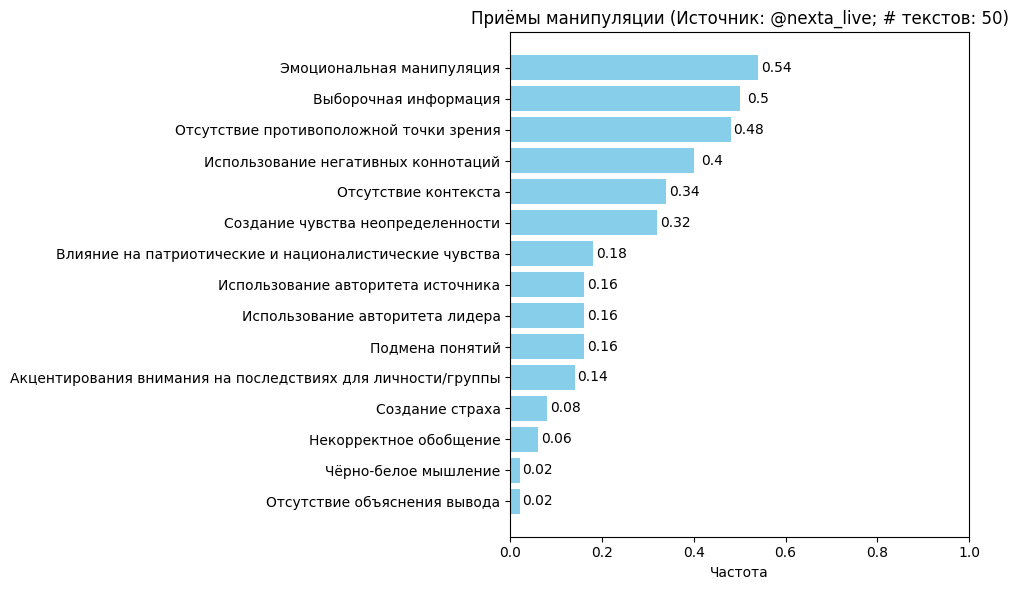

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


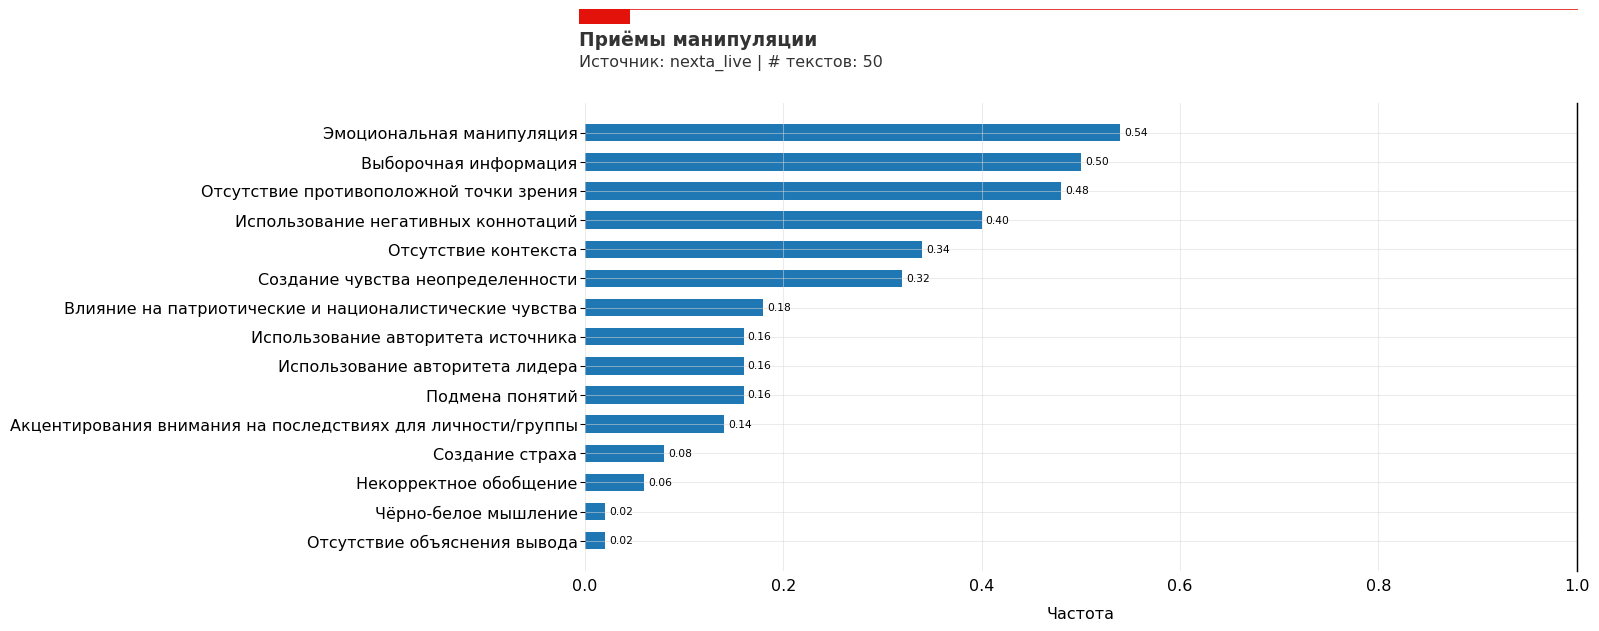

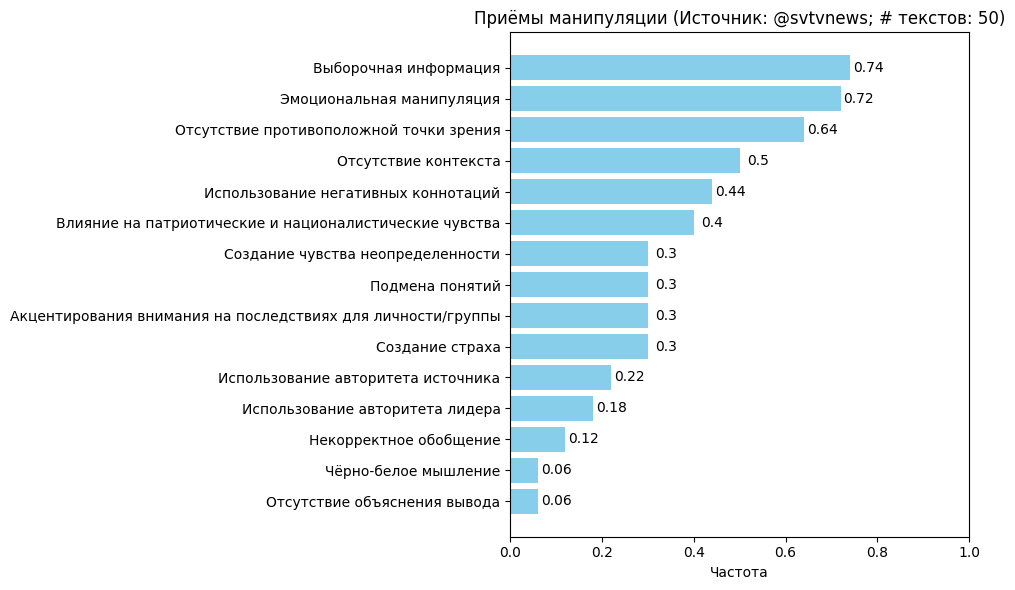

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


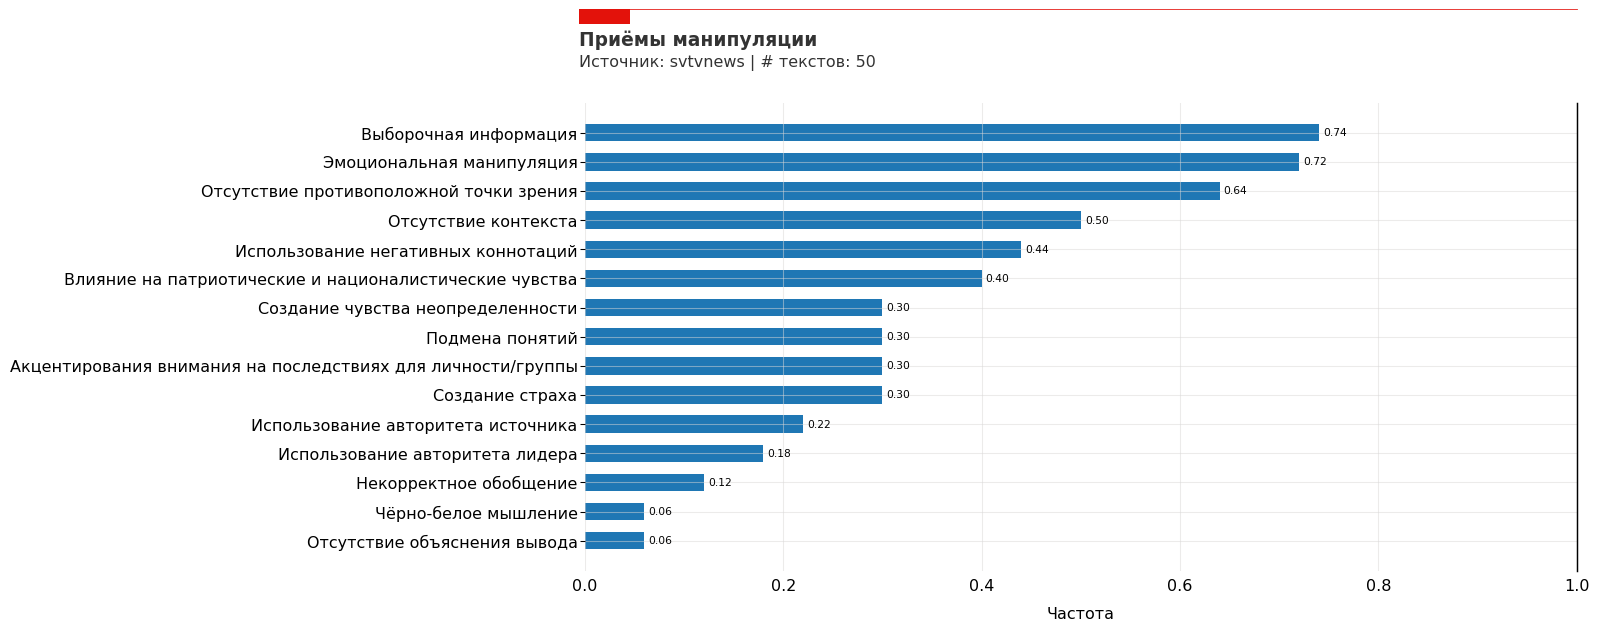

In [228]:
for source in source2manipulation_methods.keys():
    labels, values = plot_source_info(relabeled_methods, augmented_records, source = source)
    pretty_plot_source_info(labels, values, augmented_records, source)